In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy import interpolate
from scipy import signal
import scipy.fft as f
from scipy.signal import savgol_filter
import scipy.linalg
import random
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.interpolate import UnivariateSpline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import lasio
from scipy.interpolate import interp1d

In [2]:
df_forge = pd.read_excel('/Users/prathikprasad/Desktop/DataRepo Hook Load/16A-32_BHA18.xlsx')

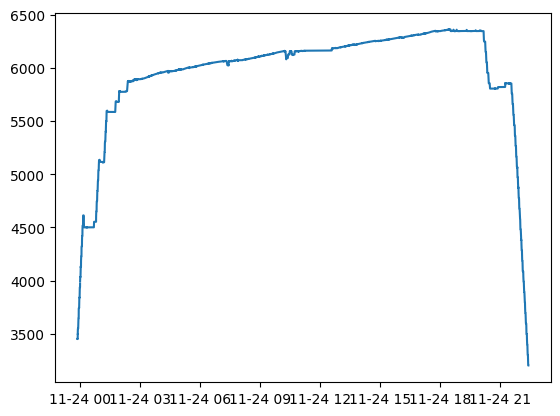

In [6]:
plt.plot(df_forge['DateTime'],df_forge['Surface_Depth - Bit(ft)'])

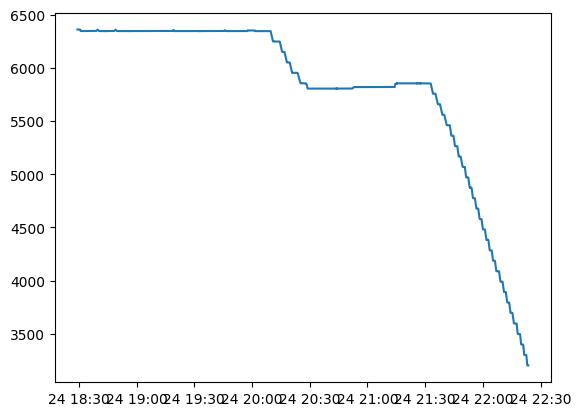

In [3]:
df_forge_tripout = df_forge.loc[df_forge['Surface_Depth - Bit(ft)'].idxmax():]

plt.plot(df_forge_tripout['DateTime'] , df_forge_tripout['Surface_Depth - Bit(ft)'])

In [4]:
df_forge_tripout = df_forge_tripout[df_forge_tripout['Surface_Hookload(klbs)']> 100]

# df_forge_tripout_filter = df_forge_tripout[(df_forge_tripout['Surface_Hookload(klbs)']< 95) & (df_forge_tripout['Surface_Hookload(klbs)']> 5)]

In [5]:
def buoyancy_factor(bha_weight_air_klbs, bha_weight_mud_klbs):
    bha_weight_air_lbs = bha_weight_air_klbs * 1000  # Convert kilopounds to pounds
    bha_weight_mud_lbs = bha_weight_mud_klbs * 1000  # Convert kilopounds to pounds
    return 1 - (bha_weight_mud_lbs / bha_weight_air_lbs)


def calculate_hook_load_and_overpull(df, weight_per_unit_length, bf, bha_weight_lbs):
    df['Theoretical Hook Load (klbs)'] = (((df['Surface_Depth - Bit(ft)'] * weight_per_unit_length * (1 - bf)) + bha_weight_lbs) / 1000)
    df['Overpull (klbs)'] = df['Surface_Hookload(klbs)'] - df['Theoretical Hook Load (klbs)']
    df['Overpull (klbs)'] = df['Overpull (klbs)'].apply(lambda x: x if x > 0 else 0)

In [6]:
bf = buoyancy_factor(131.95 , 114.93 )
calculate_hook_load_and_overpull(df_forge_tripout, 35, bf, 75 * 1000) 

In [39]:
fig = make_subplots(rows =1  , cols = 1 , shared_xaxes= True)

fig.add_trace(go.Scatter(x = df_forge_tripout['Surface_Hookload(klbs)'] , y = df_forge_tripout['Surface_Depth - Bit(ft)'] , name = 'Surface Hookload (klbs)'), row = 1 , col = 1)

fig.add_trace(go.Scatter(x = df_forge_tripout['Theoretical Hook Load (klbs)'] , y = df_forge_tripout['Surface_Depth - Bit(ft)'] , name = 'Theoretical Hook Load (klbs)'), row = 1 , col = 1)
fig.update_yaxes(title_text='Bit Depth (ft)' , row=1, col=1, autorange="reversed")
fig.update_layout(title = 'Hookload and Theoretical Hookload' , xaxis_title = 'Date Time' , yaxis_title = 'Hookload (klbs)')
fig.show()

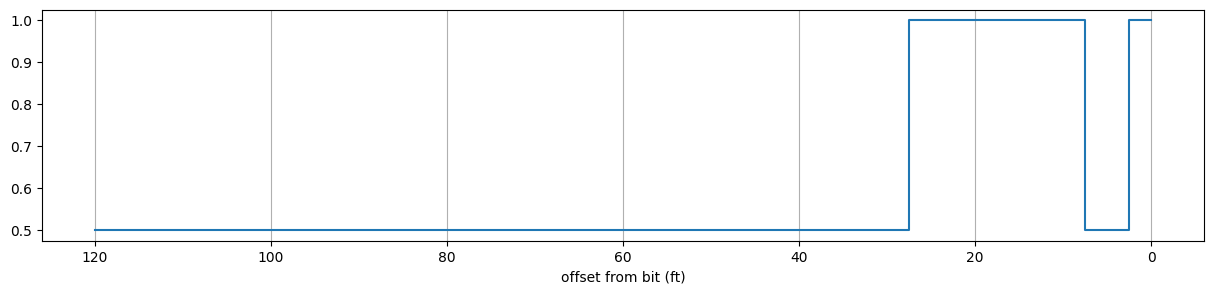

In [9]:
dz = 5
bha_length = 125
x = np.arange(bha_length*2, step=dz)
BHA_stab_flag_1 = np.ones(int(bha_length*2/dz))*0.5
BHA_stab_flag_dirac_1 = BHA_stab_flag_1.copy()
bit = [0.3327283410878418, 0.5627845217107046]
bit_ind = int(len(BHA_stab_flag_1)/2 + bit[1]//dz)
stab1_22 = [10, 30]  #BHA22
stab2_22 = [120.9 - 8.41 , 120.9]  # BHA22

stab1_ind = [int(len(BHA_stab_flag_1)/2+stab1_22[0]//dz),int(len(BHA_stab_flag_1)/2+stab1_22[1]//dz)]

# stab2_ind = [int(len(BHA_stab_flag_1)/2+stab2_22[0]//dz),int(len(BHA_stab_flag_1)/2+stab2_22[1]//dz)]

BHA_stab_flag_1[bit_ind] = 1
BHA_stab_flag_1[stab1_ind[0]:stab1_ind[1]] = 1
# BHA_stab_flag_1[stab2_ind[0]:stab2_ind[1]] = 1

plt.step(x[:int(bha_length/dz)], BHA_stab_flag_1[int(bha_length/dz):],where='mid')

plt.gcf().set_size_inches(15,3)
plt.xlabel('offset from bit (ft)')
plt.gca().invert_xaxis()
# plt.xlim(135,145)
plt.grid(axis='x')
plt.show()


In [10]:
def LSQ_deconv(sig, w, stab=1e+2, Cnum = 0.009):
    A = scipy.linalg.convolution_matrix(w, len(sig), 'same')
    Cnum_temp = np.linalg.cond(np.matmul(A.transpose(),A))
    if Cnum_temp >=1e+9:
        print("Condition number :" , Cnum_temp)
        print("Condition number is too large so that a very samll errror can aslo get amplified!")
        A += stab*np.std(w) * np.diag(np.ones(A.shape[1]))
        recovered, _, _, _ = scipy.linalg.lstsq(A, sig,cond=Cnum)
    else: 
        recovered, _, _, _ = scipy.linalg.lstsq(A, sig)

    return recovered

In [11]:
df_forge_tripout['Smoothed Overpull (klbs)'] = savgol_filter(df_forge_tripout['Overpull (klbs)'], window_length=5, polyorder=3, mode='interp')

df_forge_tripout['Smoothed Hook Load (klbs)'] = savgol_filter(df_forge_tripout['Surface_Hookload(klbs)'], window_length=5, polyorder=3, mode='interp')

In [12]:
fig = make_subplots(rows =1  , cols = 1 , shared_xaxes= True)

fig.add_trace(go.Scatter(x = df_forge_tripout['Smoothed Hook Load (klbs)'] , y = df_forge_tripout['Surface_Depth - Bit(ft)'] , name = 'Surface Hookload (klbs)'), row = 1 , col = 1)

fig.add_trace(go.Scatter(x = df_forge_tripout['Theoretical Hook Load (klbs)'] , y = df_forge_tripout['Surface_Depth - Bit(ft)'] , name = 'Theoretical Hook Load (klbs)'), row = 1 , col = 1)
fig.update_yaxes(title_text='Bit Depth (ft)' , row=1, col=1, autorange="reversed")
fig.update_layout(title = 'Hookload and Theoretical Hookload' , xaxis_title = 'Date Time' , yaxis_title = 'Hookload (klbs)')
fig.show()

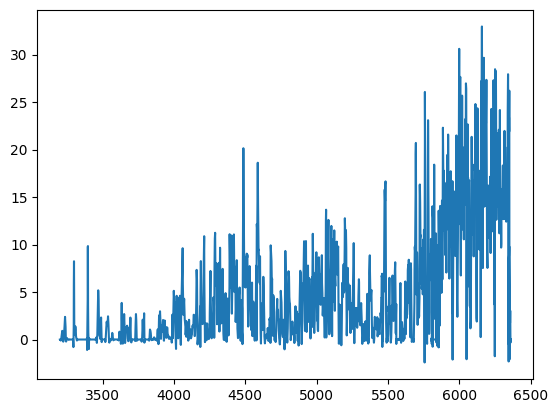

In [70]:
plt.plot(df_forge_tripout['Surface_Depth - Bit(ft)'] , df_forge_tripout['Smoothed Overpull (klbs)'])

In [13]:
decon_result = LSQ_deconv(df_forge_tripout['Smoothed Hook Load (klbs)'], BHA_stab_flag_1, stab=1e+2, Cnum=1e+9)
df_forge_tripout['Deconvolved Overpull (klbs)'] = decon_result

Condition number : 3.6666243154586394e+18
Condition number is too large so that a very samll errror can aslo get amplified!


In [14]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=df_forge_tripout['Surface_Depth - Bit(ft)'], y=decon_result, name=f'Deconvolved Overpull (klbs)'),
)
fig.add_trace(go.Scatter(x=df_forge_tripout['Surface_Depth - Bit(ft)'], y=df_forge_tripout['Smoothed Overpull (klbs)'], name=f' Overpull'),
              row=2, col=1)



fig.show()